In [1]:
dict_wl_sims = {}
# dict_rw_sims = {}
dict_matching_labels = {}
dict_gin_sims = {}
# num_samples = 20

In [2]:
%load_ext autoreload
%autoreload 2

import argparse
from itertools import product

from datasets import get_dataset
from gin import GIN
from train_eval import cross_validation_with_val_set

from torch_geometric.utils import to_networkx
import torch

import grakel
from grakel.kernels import WeisfeilerLehman, VertexHistogram, RandomWalk
from grakel.utils import graph_from_networkx

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--lr', type=float, default=0.01)
parser.add_argument('--lr_decay_factor', type=float, default=0.5)
parser.add_argument('--lr_decay_step_size', type=int, default=50)
args = parser.parse_args("")

layers = [4]
hiddens = [64]
all_datasets = ['IMDB-BINARY', 'IMDB-MULTI', 'REDDIT-BINARY', 'MUTAG', 'PTC_MR', 'PROTEINS']
nets = [GIN]

In [6]:
dict_nx_dataset = {}
dict_labels = {}
dict_torch_dataset = {}

for dataset_name in all_datasets:
    torch_dataset = []
    nx_dataset = []
    labels = []
    
    dataset = get_dataset(dataset_name)
    
    for G_torch in dataset:
        G_nx = to_networkx(G_torch, node_attrs=['x'])
        # convert node attrs to tuple so are hashable
        for node in G_nx.nodes():
            if isinstance(G_nx.nodes[node]['x'], list):
                G_nx.nodes[node]['x'] = tuple(G_nx.nodes[node]['x'])
        
        torch_dataset.append(G_torch)
        nx_dataset.append(G_nx)
        labels.append(G_torch.y[0].item())
        
    nx_dataset = list(zip(nx_dataset, labels, torch_dataset))
    # nx_dataset = random.sample(nx_dataset, num_samples)
    torch_dataset = list(list(zip(*nx_dataset))[2])
    labels = list(list(zip(*nx_dataset))[1])
    nx_dataset = list(list(zip(*nx_dataset))[0])
    
    dict_nx_dataset[dataset_name] = nx_dataset
    dict_labels[dataset_name] = labels
    dict_torch_dataset[dataset_name] = torch_dataset

In [5]:
for dataset_name in all_datasets:

    print("======", dataset_name, "======")
    nx_dataset = dict_nx_dataset[dataset_name]
    gd = list(graph_from_networkx(nx_dataset, node_labels_tag='x'))
    
    wl_gk = WeisfeilerLehman(n_iter=4, base_graph_kernel=VertexHistogram, normalize=True)
    wl_sims = wl_gk.fit_transform(gd)
    dict_wl_sims[dataset_name] = wl_sims
    
#     rw_gk = RandomWalk(normalize=True)
#     rw_sims = rw_gk.fit_transform(gd)
#     dict_rw_sims[dataset_name] = rw_sims

====== IMDB-BINARY ======
====== IMDB-MULTI ======
====== REDDIT-BINARY ======
====== MUTAG ======
====== PTC_MR ======
====== PROTEINS ======


In [4]:
import numpy as np

# for dataset_name in all_datasets:
        
#     with open('./kernels/{}_wl.npy'.format(dataset_name), 'wb') as f:
#         np.save(f, dict_wl_sims[dataset_name], allow_pickle=True)
        
# #     with open('./kernels/{}_rw.npy'.format(dataset_name), 'wb') as f:
# #         np.save(f, dict_rw_sims[dataset_name])

for dataset_name in all_datasets:
    with open('./kernels/{}_wl.npy'.format(dataset_name), 'rb') as f:
        dict_wl_sims[dataset_name] = np.load(f, allow_pickle=True)
        
    print(dict_wl_sims[dataset_name].shape)

(1000, 1000)
(1500, 1500)
(2000, 2000)
(188, 188)
(344, 344)
(1113, 1113)


In [7]:
for dataset_name in all_datasets:
    
    print("======", dataset_name, "======")
    
    labels = dict_labels[dataset_name]
    matching_labels = torch.zeros(len(labels), len(labels))
    for idx_i, lbl_i in enumerate(labels):
        for idx_j, lbl_j in enumerate(labels):
            if lbl_i == lbl_j:
                matching_labels[idx_i, idx_j] = 1
    dict_matching_labels[dataset_name] = matching_labels

====== IMDB-BINARY ======
====== IMDB-MULTI ======
====== REDDIT-BINARY ======
====== MUTAG ======
====== PTC_MR ======
====== PROTEINS ======


In [8]:
from torch_geometric import seed_everything

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

results = []
models = []

seeds = [0, 42, 87, 21, 35, 34, 120, 3, 76, 39]

for dataset_name, Net in product(all_datasets, nets):
    for seed in seeds:
        seed_everything(seed)

        best_result = (float('inf'), 0, 0)  # (loss, acc, std)
        best_model = None
        print(f'--\n{dataset_name} - {Net.__name__}')
        for num_layers, hidden in product(layers, hiddens):
            print(f'--\n{num_layers} - {hidden}')
            dataset = get_dataset(dataset_name)
            model = Net(dataset, num_layers, hidden).to(device)
            loss, acc, std = cross_validation_with_val_set(
                dataset,
                model,
                folds=10,
                epochs=args.epochs,
                batch_size=args.batch_size,
                lr=args.lr,
                lr_decay_factor=args.lr_decay_factor,
                lr_decay_step_size=args.lr_decay_step_size,
                weight_decay=0,
                logger=None,
            )
            if loss < best_result[0]:
                best_result = (loss, acc, std)
                best_model = model

        desc = f'{best_result[1]:.3f} ± {best_result[2]:.3f}'
        print(f'Best result - {desc}')
        results += [f'{dataset_name} - {model}: {desc}']
        models.append(best_model)
results = '\n'.join(results)
print(f'--\n{results}')

--
IMDB-BINARY - GIN
--
4 - 64
Val Loss: 0.4788, Test Accuracy: 0.720 ± nan, Duration: 24.533
Best result - 0.720 ± nan
--
IMDB-BINARY - GIN
--
4 - 64
Val Loss: 0.4818, Test Accuracy: 0.740 ± nan, Duration: 23.576
Best result - 0.740 ± nan
--
IMDB-BINARY - GIN
--
4 - 64
Val Loss: 0.5043, Test Accuracy: 0.700 ± nan, Duration: 23.307
Best result - 0.700 ± nan
--
IMDB-BINARY - GIN
--
4 - 64
Val Loss: 0.4813, Test Accuracy: 0.780 ± nan, Duration: 23.346
Best result - 0.780 ± nan
--
IMDB-BINARY - GIN
--
4 - 64
Val Loss: 0.4660, Test Accuracy: 0.730 ± nan, Duration: 22.983
Best result - 0.730 ± nan
--
IMDB-BINARY - GIN
--
4 - 64
Val Loss: 0.4897, Test Accuracy: 0.740 ± nan, Duration: 23.496
Best result - 0.740 ± nan
--
IMDB-BINARY - GIN
--
4 - 64
Val Loss: 0.4835, Test Accuracy: 0.760 ± nan, Duration: 22.636
Best result - 0.760 ± nan
--
IMDB-BINARY - GIN
--
4 - 64
Val Loss: 0.4955, Test Accuracy: 0.700 ± nan, Duration: 22.334
Best result - 0.700 ± nan
--
IMDB-BINARY - GIN
--
4 - 64
Val Loss:

In [14]:
from torch_geometric.loader import DataLoader

for idx, model in enumerate(models):
    seed = seeds[idx % 10]
    dataset_name = all_datasets[idx // 10]
    
    dataset = get_dataset(dataset_name)
    test_loader = DataLoader(dataset, len(dataset), shuffle=False) 

    for data in test_loader:
        data = data.to(device)
        with torch.no_grad():
            x_repr = model(data, ret_repr=True)

            normed_x_repr = x_repr / x_repr.norm(dim=1, keepdim=True)
            dict_gin_sims[dataset_name + "_" + str(seed)] = (normed_x_repr @ normed_x_repr.T).cpu().detach()

            with open('./kernels/{}_gin.npy'.format(dataset_name + "_" + str(seed)), 'wb') as f:
                np.save(f, dict_gin_sims[dataset_name + "_" + str(seed)], allow_pickle=True)

In [45]:
for dataset_name in all_datasets:
    for seed in seeds:
        with open('./kernels/{}_gin.npy'.format(dataset_name + "_" + str(seed)), 'rb') as f:
            dict_gin_sims[dataset_name + "_" + str(seed)] = np.load(f, allow_pickle=True)

        print(dict_gin_sims[dataset_name + "_" + str(seed)].shape)

(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1500, 1500)
(1500, 1500)
(1500, 1500)
(1500, 1500)
(1500, 1500)
(1500, 1500)
(1500, 1500)
(1500, 1500)
(1500, 1500)
(1500, 1500)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(2000, 2000)
(188, 188)
(188, 188)
(188, 188)
(188, 188)
(188, 188)
(188, 188)
(188, 188)
(188, 188)
(188, 188)
(188, 188)
(344, 344)
(344, 344)
(344, 344)
(344, 344)
(344, 344)
(344, 344)
(344, 344)
(344, 344)
(344, 344)
(344, 344)
(1113, 1113)
(1113, 1113)
(1113, 1113)
(1113, 1113)
(1113, 1113)
(1113, 1113)
(1113, 1113)
(1113, 1113)
(1113, 1113)
(1113, 1113)


In [47]:
from sklearn.metrics import adjusted_mutual_info_score, mutual_info_score

def calc_MI(x, y, bins=20):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

====== IMDB-BINARY ======
====== IMDB-MULTI ======
====== REDDIT-BINARY ======
====== MUTAG ======
====== PTC_MR ======
====== PROTEINS ======


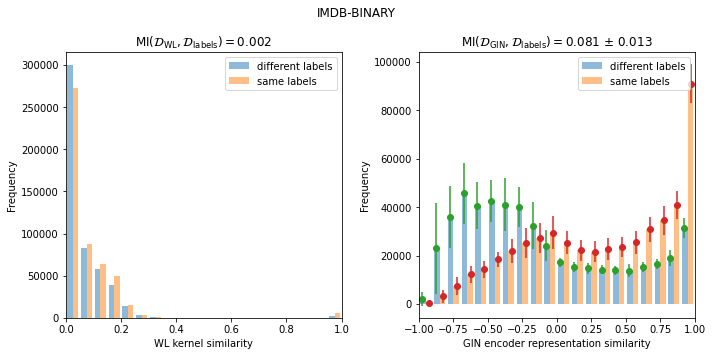

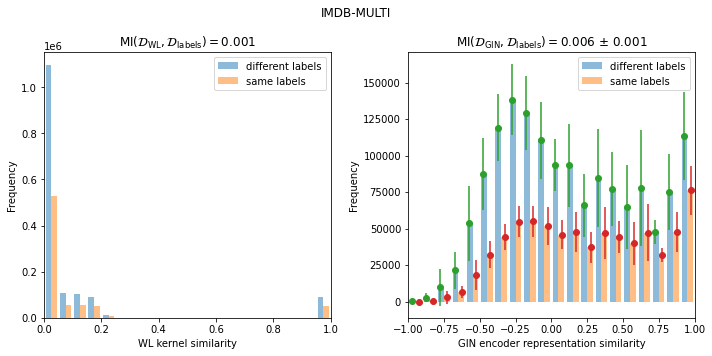

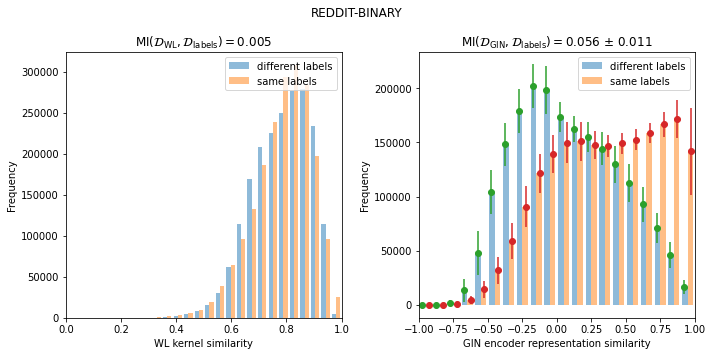

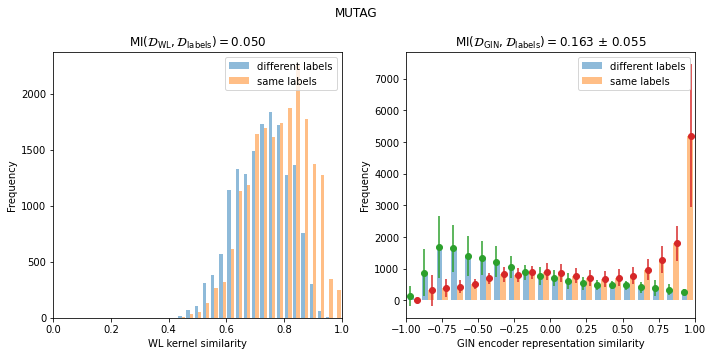

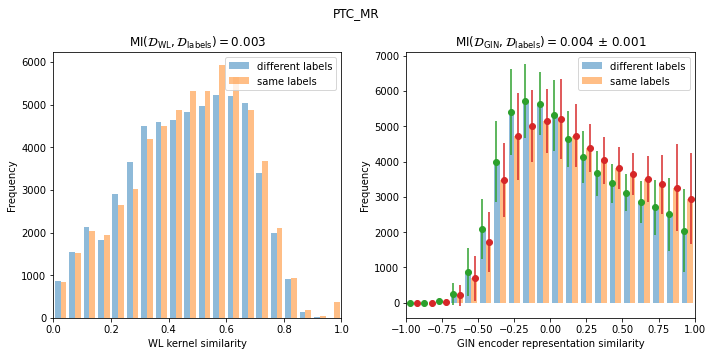

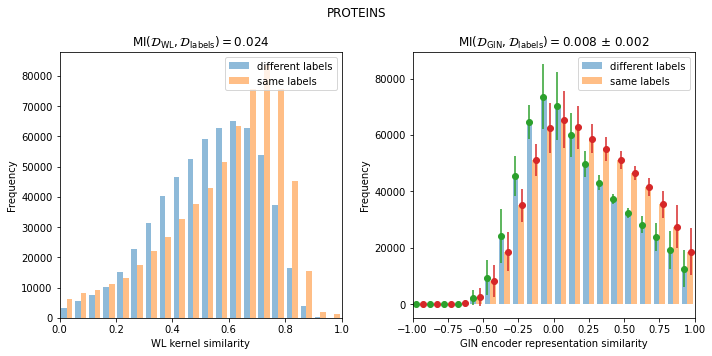

In [49]:
import matplotlib.pyplot as plt
rc = {"font.family" : "sans-serif", 
      "mathtext.fontset" : "dejavusans"}
plt.rcParams.update(rc)

for dataset_name in all_datasets:
    print("======", dataset_name, "======")
    
    wl_sims = dict_wl_sims[dataset_name]
    matching_labels = dict_matching_labels[dataset_name].numpy()

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    d1 = wl_sims.flatten()[matching_labels.flatten() == 0]
    d2 = wl_sims.flatten()[matching_labels.flatten() == 1]
    plt.hist([d1, d2], bins=20, alpha=0.5, label=['different labels', 'same labels'])
    plt.xlim(0, 1)

    association = calc_MI(wl_sims.flatten(), matching_labels.flatten())

    plt.title(r'$\mathrm{MI}({\cal D}_{\mathrm{WL}}, {\cal D}_{\mathrm{labels}}) = $' + '{0:.3f}'.format(association))
    plt.legend(loc='upper right')
    plt.ylabel("Frequency")
    plt.xlabel("WL kernel similarity")
    
    d1_counts = np.zeros((len(seeds), 20))
    d2_counts = np.zeros((len(seeds), 20))
    for idx, seed in enumerate(seeds):
        gin_sims = dict_gin_sims[dataset_name + "_" + str(seed)]
        d1 = gin_sims.flatten()[matching_labels.flatten() == 0]
        d2 = gin_sims.flatten()[matching_labels.flatten() == 1]
        
        d1_counts[idx], bins = np.histogram(d1, bins=20, range=(-1,1))
        d2_counts[idx], _ = np.histogram(d2, bins=20, range=(-1,1))
    d1_counts_mean = np.mean(d1_counts, axis=0)
    d1_counts_std = np.std(d1_counts, axis=0)
    d2_counts_mean = np.mean(d2_counts, axis=0)
    d2_counts_std = np.std(d2_counts, axis=0)

    plt.subplot(1, 2, 2)
    [n1, n2], bins, _ = plt.hist([bins[:-1], bins[:-1]], bins, alpha=0.5, weights=[d1_counts_mean, d2_counts_mean], label=['different labels', 'same labels'])
    mid = 0.5*(bins[1:] + bins[:-1])
    mid1 = 0.5*(mid + bins[:-1])
    mid2 = 0.5*(bins[1:] + mid)
    plt.errorbar(mid1, n1, yerr=d1_counts_std, fmt ='o')
    plt.errorbar(mid2, n2, yerr=d2_counts_std, fmt ='o')
    plt.xlim(-1, 1)

    associations = np.zeros(10)
    for idx, seed in enumerate(seeds):
        associations[idx] = calc_MI(dict_gin_sims[dataset_name + "_" + str(seed)].flatten(), matching_labels.flatten())
    associations_mean = np.mean(associations)
    associations_std = np.std(associations)

    plt.title(r'$\mathrm{MI}({\cal D}_{\mathrm{GIN}}, {\cal D}_{\mathrm{labels}}) = $' + '{0:.3f}'.format(associations_mean) + " ± " + '{0:.3f}'.format(associations_std))
    plt.legend(loc='upper right')
    plt.ylabel("Frequency")
    plt.xlabel("GIN encoder representation similarity")

    plt.suptitle(dataset_name)
    plt.tight_layout()

    plt.savefig("./plots/alignment/{}.pdf".format(dataset_name))